In [1]:
!pip install gdown
!pip install tensorflow.gpu

     |████████████████████████████████| 394.3MB 44kB/s 


In [70]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from google.colab import drive
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import keras
import pickle

In [82]:
# load dfset
drive.mount('/drive')   #mount the drive to load 

df = pd.read_csv('/drive/Shareddrives/CSE 573: Team Project/Data Sets/Anomaly/Anomaly/EURUSD1.csv')
df.columns =["date","time", "open", "high", "low", "close", "volume"]

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [83]:
df.head() # print the first 5 rows of df

,date,time,open,high,low,close,volume
0,2004.07.29,08:54,1.2027,1.2028,1.2021,1.2022,9
1,2004.07.29,08:55,1.2026,1.2029,1.2023,1.2027,9
2,2004.07.29,08:56,1.2024,1.2026,1.2021,1.2023,9
3,2004.07.29,08:57,1.2022,1.2026,1.2017,1.2023,12
4,2004.07.29,08:58,1.2022,1.2030,1.2018,1.2022,19


In [84]:
df.shape # number of rows and columns

(6001885, 7)

In [85]:
# preprocess data

#convert to date time format
df['date_time'] = df['date'] + " " + df['time']
df['date_time'] = pd.to_datetime(df['date_time'],format="%Y.%m.%d %H:%M")
print(df['date_time'].max())
print(df['date_time'].min())

2021-01-28 20:34:00
2004-07-29 08:54:00


In [87]:
# split data into train and test
df = df.loc[(df['date_time'] >= '2010-01-01') & (df['date_time'] <= '2015-01-01')]
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(1749766, 8) (92093, 8)


In [88]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [90]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)
print(X_train.shape)

(1749736, 30, 1)


In [91]:
# Create model
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

In [92]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
49212/49212 [==============================] - 1187s 24ms/step - loss: 0.0811 - val_loss: 0.6385
Epoch 2/10
49212/49212 [==============================] - 1272s 26ms/step - loss: 0.0849 - val_loss: 0.6178
Epoch 3/10
49212/49212 [==============================] - 1290s 26ms/step - loss: 0.0701 - val_loss: 0.4954
Epoch 4/10
49212/49212 [==============================] - 1259s 26ms/step - loss: 0.0679 - val_loss: 0.4416
Epoch 5/10
49212/49212 [==============================] - 1262s 26ms/step - loss: 0.0666 - val_loss: 0.4464
Epoch 6/10
49212/49212 [==============================] - 1261s 26ms/step - loss: 0.0647 - val_loss: 0.4894
Epoch 7/10
49212/49212 [==============================] - 1280s 26ms/step - loss: 0.0684 - val_loss: 0.4784
Epoch 8/10
49212/49212 [==============================] - 1268s 26ms/step - loss: 0.0692 - val_loss: 0.5298
Epoch 9/10
49212/49212 [==============================] - 1278s 26ms/step - loss: 0.0707 - val_loss: 0.4556
Epoch 10/10
49212/49212 [===

In [93]:
# Finding Anomalies
# MAE = Mean Absolute Error
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [94]:
print(train_mae_loss)

[[0.74213432]
 [0.78101745]
 [0.7590526 ]
 ...
 [2.13572381]
 [2.13605423]
 [2.13622957]]


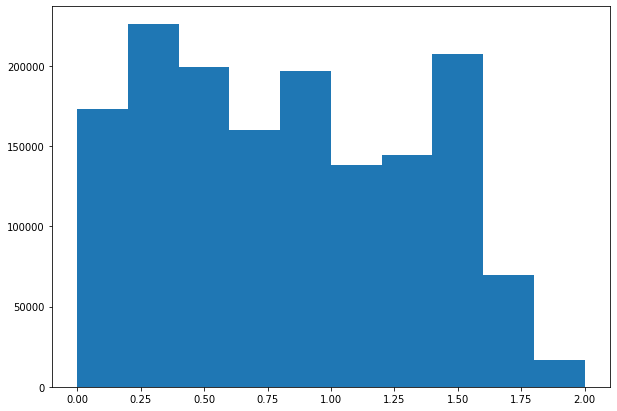

In [95]:
fig, ax = plt.subplots(figsize =(10, 7)) 
ax.hist(train_mae_loss, bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]) 
  
# Show plot 
plt.show() 

In [104]:
# Test model
THRESHOLD = 1.95
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [105]:
# DataFrame for loss and anomalies
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

In [106]:
# print(test_score_df['loss'])
print(test_score_df.shape)
# print(test_score_df.head())

(92063, 4)


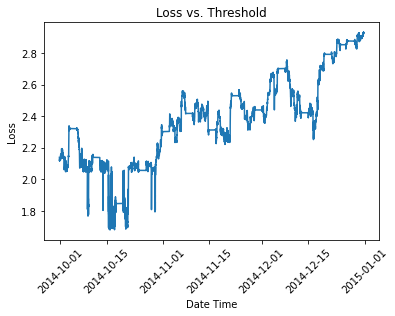

In [107]:
#plt.figure(figsize=(100,50))
plt.plot(test[TIME_STEPS:]['date_time'],test_score_df['loss'])
plt.title('Loss vs. Threshold')
plt.xlabel('Date Time')
plt.ylabel('Loss')
plt.xticks(rotation=45) # space out labels
plt.show()

In [108]:
anomalies = test_score_df[test_score_df.anomaly == True]
print(anomalies)

             loss  threshold  anomaly     close
3652789  2.138009       1.95     True -1.349163
3652790  2.137541       1.95     True -1.344058
3652791  2.137011       1.95     True -1.345152
3652792  2.136439       1.95     True -1.345699
3652793  2.135997       1.95     True -1.343876
...           ...        ...      ...       ...
3744847  2.929100       1.95     True -2.302312
3744848  2.929560       1.95     True -2.303953
3744849  2.929134       1.95     True -2.304135
3744850  2.929000       1.95     True -2.303953
3744851  2.929055       1.95     True -2.304135

[85936 rows x 4 columns]


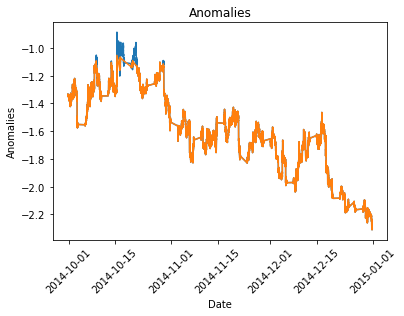

In [109]:
#plt.figure(figsize=(100,50))
plt.plot(test[TIME_STEPS:]['date_time'],test_score_df['close'])
plt.plot(test[TIME_STEPS:][test_score_df['anomaly'] == True]['date_time'],test_score_df[test_score_df['anomaly'] == True]['close'])
plt.title('Anomalies')
plt.xlabel('Date')
plt.ylabel('Anomalies')
plt.xticks(rotation=45) # space out labels
plt.show()

In [110]:
# Save model
model.save('')

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets
